In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

ROOT = Path.cwd().parents[1]   # adjust if your notebook opens inside notebooks/
RAW_PATH = ROOT / "data" / "01-raw"


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -------------------------------------------
# FIXED ROOT PATH (WORKS 100% IN YOUR PROJECT)
# -------------------------------------------
# notebooks/EDA.ipynb -> project root is 1 level up
ROOT = Path.cwd().resolve().parents[1]

# raw data folder
RAW_PATH = ROOT / "data" / "01-raw"

print("PROJECT ROOT:", ROOT)
print("RAW PATH:", RAW_PATH)
print("File exists:", (RAW_PATH / "train_FD001.txt").exists())


PROJECT ROOT: C:\Users\HP
RAW PATH: C:\Users\HP\data\01-raw
File exists: False


Current working directory (cwd): C:\Users\HP\ml-predictive-maintenance\notebooks

Parent chain (top -> bottom):
 parent[0] -> C:\
 parent[1] -> C:\Users
 parent[2] -> C:\Users\HP
 parent[3] -> C:\Users\HP\ml-predictive-maintenance
 parent[last] -> C:\Users\HP\ml-predictive-maintenance\notebooks

Detected PROJECT_ROOT: C:\Users\HP\ml-predictive-maintenance
RAW_PATH -> C:\Users\HP\ml-predictive-maintenance\data\01-raw
train_FD001 exists? -> True

Loaded dataframe shape: (20631, 26)


,unit,time_cycle,setting1,setting2,setting3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


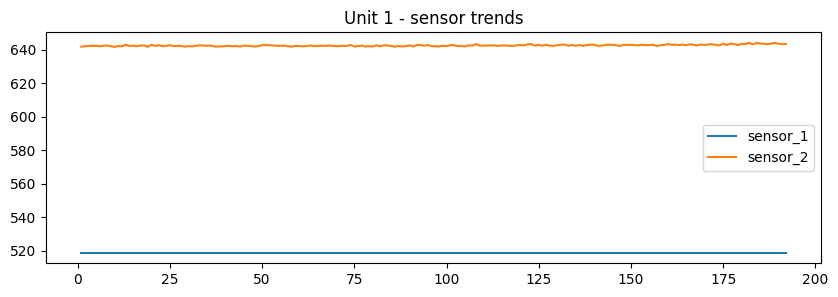

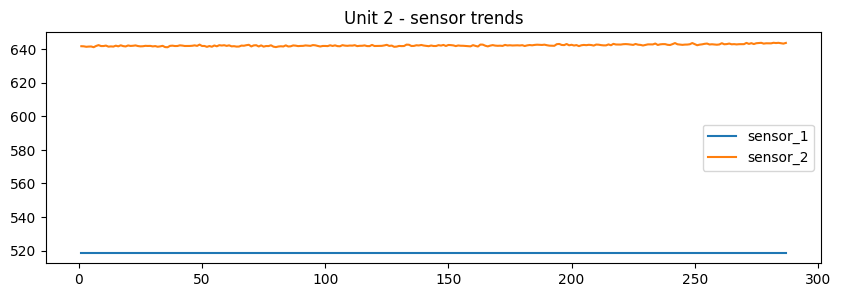

In [15]:
# Robust path finder + dataset loader for CMAPSS (copy-paste this whole cell)
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import sys

# --- DEBUG: show where the notebook is running from ---
cwd = Path.cwd().resolve()
print("Current working directory (cwd):", cwd)

print("\nParent chain (top -> bottom):")
for i, p in enumerate(reversed(list(cwd.parents))):  # top-level first
    print(f" parent[{i}] -> {p}")
print(f" parent[last] -> {cwd}")  # show the cwd at the end

# --- Find project root by walking up until we find a folder that contains 'data/01-raw' ---
def find_project_root(start: Path, marker_dirs=("data", "notebooks", "src")) -> Path:
    """
    Walk up from start. Return first parent that contains 'data' directory (and preferably notebooks).
    If nothing found, raise an informative error.
    """
    for p in [start] + list(start.parents):
        # prefer parent that contains 'data/01-raw'
        if (p / "data" / "01-raw").exists():
            return p
        # fallback: project with data dir and notebooks dir
        if (p / "data").exists() and (p / "notebooks").exists():
            return p
        # fallback2: project with requirements file
        if (p / "requirements.txt").exists():
            return p
    raise FileNotFoundError("Could not find project root (looked for data/01-raw or requirements.txt). "
                            "Make sure your notebook is inside the project folder or move files accordingly.")

try:
    PROJECT_ROOT = find_project_root(cwd)
except Exception as e:
    print("\nERROR: couldn't locate project root automatically.")
    print("Make sure your notebook is inside the 'ml-predictive-maintenance' folder or move it there.")
    raise

print("\nDetected PROJECT_ROOT:", PROJECT_ROOT)

RAW_PATH = PROJECT_ROOT / "data" / "01-raw"
print("RAW_PATH ->", RAW_PATH)
print("train_FD001 exists? ->", (RAW_PATH / "train_FD001.txt").exists())

# --- If file exists, load it. Otherwise stop with clear message. ---
if not (RAW_PATH / "train_FD001.txt").exists():
    raise FileNotFoundError(f"train_FD001.txt not found at {RAW_PATH}. "
                            "If the file is elsewhere, move it to data/01-raw or update RAW_PATH.")

# column names for CMAPSS (26 columns)
col_names = [
    "unit",
    "time_cycle",
    "setting1", "setting2", "setting3"
] + [f"sensor_{i}" for i in range(1, 22)]

# load file
df = pd.read_csv(RAW_PATH / "train_FD001.txt", sep=r"\s+", header=None, names=col_names)
print("\nLoaded dataframe shape:", df.shape)
display(df.head())

# quick example plot (optional)
sample_units = df['unit'].unique()[:2]
for u in sample_units:
    tmp = df[df['unit'] == u]
    plt.figure(figsize=(10,3))
    plt.plot(tmp['time_cycle'], tmp['sensor_1'], label='sensor_1')
    plt.plot(tmp['time_cycle'], tmp['sensor_2'], label='sensor_2')
    plt.title(f"Unit {u} - sensor trends")
    plt.legend()
    plt.show()


In [16]:
# Compute max cycle per unit
max_cycles = df.groupby("unit")["time_cycle"].max().reset_index()
max_cycles.columns = ["unit", "max_cycle"]

# Merge with original DF
df = df.merge(max_cycles, on="unit", how="left")

# RUL = (max_cycle - time_cycle)
df["RUL"] = df["max_cycle"] - df["time_cycle"]
df.head()


,unit,time_cycle,setting1,setting2,setting3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,max_cycle,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192,187


In [17]:
N = 30
df["failure_within_30"] = (df["RUL"] <= N).astype(int)
df.head()


,unit,time_cycle,setting1,setting2,setting3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,max_cycle,RUL,failure_within_30
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,192,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,192,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,192,187,0


In [22]:
!pip install pyarrow



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
!pip install fastparquet


   ---------------------------------------- 0.0/673.3 kB ? eta -:--:--
   ------------------------------- -------- 524.3/673.3 kB 3.6 MB/s eta 0:00:01
   ---------------------------------------- 673.3/673.3 kB 2.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------------ --------------------------- 0.5/1.7 MB 3.4 MB/s eta 0:00:01
   ------------------------------------ --- 1.6/1.7 MB 4.1 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 4.0 MB/s eta 0:00:00

   ---------------------------------------- 0/3 [fsspec]
   ---------------------------------------- 0/3 [fsspec]
   ---------------------------------------- 0/3 [fsspec]
   ---------------------------------------- 0/3 [fsspec]
   ---------------------------------------- 0/3 [fsspec]
   ---------------------------------------- 0/3 [fsspec]
   ------------- -------------------------- 1/3 [cramjam]
   -------------------------- ------------- 2/3 [fastparquet]
   ------


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
PREP_PATH = PROJECT_ROOT / "data" / "02-preprocessed"
PREP_PATH.mkdir(parents=True, exist_ok=True)

df.to_csv(PREP_PATH / "FD001_preprocessed.csv", index=False)


In [31]:
PREP_PATH = PROJECT_ROOT / "data" / "02-preprocessed"
df = pd.read_csv(PREP_PATH / "FD001_preprocessed.csv")

df.head()


,unit,time_cycle,setting1,setting2,setting3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,max_cycle,RUL,failure_within_30
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,192,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,192,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,192,187,0


In [33]:
import sys
sys.path.append(str(PROJECT_ROOT))
from src.pipelines.feature_pipeline import generate_features


In [34]:
df_feat = generate_features(df)
df_feat.head()


C:\Users\HP\ml-predictive-maintenance\src\pipelines\feature_pipeline.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{sensor}_r{w}_min"] = (
C:\Users\HP\ml-predictive-maintenance\src\pipelines\feature_pipeline.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{sensor}_r{w}_max"] = (
C:\Users\HP\ml-predictive-maintenance\src\pipelines\feature_pipeline.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

,unit,time_cycle,setting1,setting2,setting3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12_trend,sensor_13_trend,sensor_14_trend,sensor_15_trend,sensor_16_trend,sensor_17_trend,sensor_18_trend,sensor_19_trend,sensor_20_trend,sensor_21_trend
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
FEAT_PATH = PROJECT_ROOT / "data" / "03-features"
FEAT_PATH.mkdir(parents=True, exist_ok=True)

df_feat.to_csv(FEAT_PATH / "FD001_features.csv", index=False)


In [36]:
!pip install scikit-learn pandas joblib



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import requests
resp = requests.post(
  "http://127.0.0.1:8000/predict_simple",
  json={
    "sensors": {"sensor_1": 518.67, "sensor_2": 642.37, "sensor_3": 1582.85},
    "settings": {"setting1": 100.0}
  }
)
print(resp.json())


{'detail': "Missing required features: ['sensor_16_r5_mean', 'sensor_15_r20_min', 'sensor_15_r20_std', 'sensor_15_r20_mean', 'sensor_15_r10_max', 'sensor_15_r10_min', 'sensor_15_r10_std', 'sensor_15_r10_mean', 'sensor_15_r5_max', 'sensor_15_r5_min'] (showing up to 10)."}
